# City selection for CORDEX-CORE analysis

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cf
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
import geopandas as gpd

## Set parameters

In [2]:
proj = ccrs.Robinson()
border_color = 'grey'
cordex_color = 'lightgrey'
gp022_threshold = 0.10

## Load city database

In [3]:
# Data from Schiavina et al. (2019, CC-BY-4.0) http://doi.org/10.2905/347F0337-F2DA-4592-87B3-E25975EC2C95
# Direct download https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_FUA_UCDB2015_GLOBE_R2019A/V1-0/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.zip
city_info = gpd.read_file('data/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')
centroids = city_info.centroid.to_crs("EPSG:4326")
city_info.rename(columns = {'eFUA_name':'city', 'Cntry_name':'country'}, inplace = True)
# Handle special case of Singapore urban area across countries (Singapore and Malaysia)
city_info.loc[city_info.city == 'Singapore', 'country'] = 'Singapore'
# Add up area and pop. of duplicated cities (since some are split into parts)
city_info['area'] = city_info.groupby(['city', 'country'])['UC_area'].transform('sum')
city_info['population'] = city_info.groupby(['city', 'country'])['UC_p_2015'].transform('sum')
# Now drop duplicated city names, keep the most populated
city_info = city_info.sort_values('UC_p_2015').drop_duplicates(['city', 'country'], keep='last')
# Add some columns
city_info['density'] = city_info.population / city_info['area']
city_info['gp022'] = city_info['area'] / 600. # Approximate number of 0.22 gridpoints
city_info['lon'] = centroids.x
city_info['lat'] = centroids.y
# Remove columns no longer needed
city_info.drop(columns = ['eFUA_ID', 'UC_num', 'UC_IDs', 'Commuting', 'Cntry_ISO', 'UC_area', 'FUA_area', 'UC_p_2015', 'FUA_p_2015', 'Com_p_2015', 'geometry'], inplace = True)

# Filter data
city_info.query(f'gp022 > {gp022_threshold}', inplace = True)

In [4]:
with open('selected_cities.yaml') as fp:
  selected = yaml.load(fp, Loader=yaml.FullLoader)['cordex_core_analysis']

In [5]:
# Data from http://hanschen.org/uploads/koppen/data.zip
# see http://hanschen.org/koppen
koppen = np.genfromtxt("data/koppen_1901-2010.tsv", dtype=None, names=True, encoding=None)
koppen_color_map = dict(
   Af = '#0039fc',  Am = '#0d73fc',  As = '#379ae5',  Aw = '#6cb1e5',
  BWh = '#fd0000', BWk = '#fd9594', BSh = '#f6a200', BSk = '#e6c65a',
  Csa = '#fefa03', Csb = '#cecc09', Csc = '#908f09',
  Cwa = '#94fe97', Cwb = '#60c765', Cwc = '#359633',
  Cfa = '#c7fc4b', Cfb = '#62fd32', Cfc = '#37c600',
  Dsa = '#fc22fb', Dsb = '#c817c4', Dsc = '#993396', Dsd = '#8d5d92',
  Dwa = '#a5afff', Dwb = '#4a78e3', Dwc = '#484eb4', Dwd = '#2c1a8a',
  Dfa = '#00fcfd', Dfb = '#3ec6fa', Dfc = '#017e7e', Dfd = '#024560',
   ET = '#9e9f9e',  EF = '#5f5f5f'
)
koppen_color = pd.Series(koppen['p1901_2010'].astype('str')).map(koppen_color_map)

Add Koppen type to cities dataframe

In [6]:
def plot_cordex_boundaries():
  for border_file in glob.glob('CORDEX_domain_borders/CORDEX_*_border.dat'):
    dborder = pd.read_csv(border_file, sep=' ', header=None)
    plt.plot(*dborder.values.T, '-', color=cordex_color, transform = ccrs.PlateCarree())

def plot_koppen_zones():
  plt.scatter(
    koppen['longitude'], koppen['latitude'], s = 0.03,
    color = koppen_color, marker = 'o',
    zorder = 0, transform=ccrs.PlateCarree()
  )

@np.vectorize
def koppen_type_from_location(lon, lat):
  iloc = np.argmin((lon-koppen['longitude'])**2+(lat-koppen['latitude'])**2)
  return(koppen['p1901_2010'][iloc].astype('str'))

city_info['ktype'] = koppen_type_from_location(city_info.lon, city_info.lat)

Add CORDEX domain info

In [7]:
domain_centers = []
for border_file in glob.glob('CORDEX_domain_borders/CORDEX_*_border.dat'):
  dom = border_file.replace('CORDEX_domain_borders/CORDEX_','')
  dom = dom.replace('044_border.dat','')
  dborder = pd.read_csv(border_file, sep=' ', header=None)
  dclon, dclat = dborder.median().values
  domain_centers.append(dict(domain=dom, lon=dclon, lat=dclat))
domain_centers = pd.DataFrame(domain_centers)
domain_centers = domain_centers.set_index('domain')

@np.vectorize
def cordex_domain_from_location(lon, lat):
  iloc = np.argmin((lon-domain_centers['lon'])**2+(lat-domain_centers['lat'])**2)
  return(domain_centers.index[iloc])
city_info['domain'] = cordex_domain_from_location(city_info.lon, city_info.lat)

## City info

Save info for all cities:

In [8]:
city_info.to_csv('city_info.csv', index = False)

Display those selected by urban center area (in sq. km):

In [9]:
city_info.query(f'city in {selected}').sort_values('area')

,city,country,area,population,density,gp022,lon,lat,ktype,domain
8615,Naples,UnitedStates,67.0,6.209849e+04,926.843109,0.111667,-81.718065,26.210024,Aw,NorthAm
834,London,Canada,153.0,3.391671e+05,2216.778387,0.255000,-81.281374,42.988485,Dfb,NorthAm
8763,Tashkent,Uzbekistan,540.0,3.289974e+06,6092.545030,0.900000,69.261195,41.265650,Csa,CentralAsia
2515,Bogota,Colombia,575.0,8.785168e+06,15278.552231,0.958333,-74.121794,4.661948,Cfb,CentralAm
3277,Berlin,Germany,728.0,3.390225e+06,4656.902440,1.213333,13.374282,52.497452,Cfb,Euro
907,Santiago,Chile,745.0,6.482496e+06,8701.336608,1.241667,-70.717166,-33.500919,Csb,SouthAm
7922,Khartoum,Sudan,780.0,5.966997e+06,7649.996094,1.300000,32.516271,15.618398,BWh,Africa
122,Luanda,Angola,792.0,6.851772e+06,8651.227139,1.320000,13.336089,-8.947862,BSh,Africa
5672,Baghdad,Iraq,879.0,5.711493e+06,6497.716570,1.465000,44.390629,33.302861,BWh,WestAsia
7212,Lima,Peru,896.0,9.370164e+06,10457.772241,1.493333,-76.949891,-11.991886,ET,SouthAm


## Plot city population and area

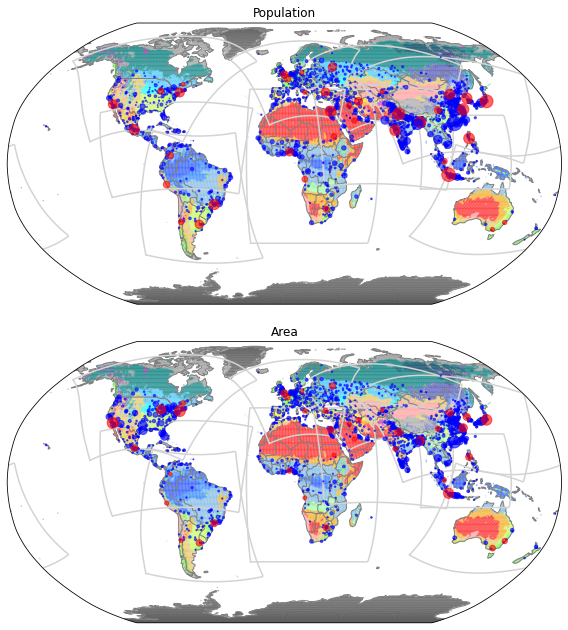

In [10]:
city_color = ['red' if x in selected else 'blue' for x in city_info.city]
fig = plt.figure(figsize=(8,9))
ax = plt.subplot(211, projection = proj)
ax.set_global()
ax.add_feature(cf.COASTLINE, edgecolor=border_color)
ax.add_feature(cf.BORDERS, edgecolor=border_color)
plot_cordex_boundaries()
plot_koppen_zones()
plt.scatter(
  city_info.lon, city_info.lat, s = city_info.population/200000.,
  color=city_color, alpha=0.6, zorder = 3, transform=ccrs.PlateCarree()
)
plt.title('Population')
#
ax = plt.subplot(212, projection = proj)
ax.set_global()
ax.add_feature(cf.COASTLINE, edgecolor=border_color)
ax.add_feature(cf.BORDERS, edgecolor=border_color)
plot_cordex_boundaries()
plot_koppen_zones()
plt.scatter(
  city_info.lon, city_info.lat, s = city_info.area/50.,
  color=city_color, alpha=0.6, zorder = 3, transform=ccrs.PlateCarree()
)
plt.title('Area')
#
plt.tight_layout()
fig.savefig('city_population_area.png', dpi=300, facecolor='white')

## Missing cities

These selected cities are missing from the database (and plots above), usually because they are too small according to the filter on `gp022`.

In [11]:
set(selected).difference(set(city_info.city))

set()

## Per domain ranking

Top 5 by population per domain:

In [12]:
n = 5
rank_var = 'population'
city_info.sort_values(['domain',rank_var], ascending=False).groupby('domain').head(n)

,city,country,area,population,density,gp022,lon,lat,ktype,domain
3728,Mumbai,India,1074.0,2.175588e+07,20256.873710,1.790000,73.036553,19.137658,Am,WestAsia
7000,Karachi,Pakistan,753.0,1.315069e+07,17464.401702,1.255000,67.101144,24.908208,BWh,WestAsia
4538,Bengaluru,India,766.0,1.139810e+07,14880.027791,1.276667,77.586777,12.983635,BSh,WestAsia
4886,Chennai,India,950.0,1.005451e+07,10583.698758,1.583333,80.126877,12.994556,Aw,WestAsia
4513,Hyderabad,India,907.0,8.290620e+06,9140.705917,1.511667,78.456362,17.419126,BSh,WestAsia
7251,Quezon City [Manila],Philippines,2416.0,2.326086e+07,9627.839785,4.026667,121.060721,14.473933,Am,SouthEastAsia
8087,Bangkok,Thailand,2648.0,1.495410e+07,5647.319131,4.413333,100.542580,13.793597,Aw,SouthEastAsia
8912,Ho Chi Minh City,Vietnam,1648.0,1.211229e+07,7349.688246,2.746667,106.695357,10.840278,Aw,SouthEastAsia
7671,Singapore,Singapore,949.0,7.130577e+06,7513.779558,1.581667,103.816375,1.352754,Af,SouthEastAsia
6046,Kuala Lumpur,Malaysia,1401.0,6.512806e+06,4648.684066,2.335000,101.592419,3.072408,Af,SouthEastAsia
